In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class Tree_node:
  def __init__(self, pos_x, pos_y):
    self.x = pos_x
    self.y = pos_y
    self.pos = np.array([self.x, self.y])

  def __repr__(self):
    return self.pos.__repr__()


In [3]:
class Attraction_point:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.pos = np.array([self.x, self.y])

  def __repr__(self):
    return self.pos.__repr__()


In [4]:
class Tree:
  def __init__(self, root):
    self.root = root
    self.nodes = [self.root]
    self.transition_map = {}

  def add_child(self, parent, child):

    if child in self.nodes:
      raise ValueError

    if parent in self.nodes:
      self.transition_map[child] = parent
      self.nodes.append(child)
    else:
      raise ValueError

  def is_leaf(self, node):
    if node not in self.nodes:
      raise ValueError
    if node not in self.transition_map.values():
      return True
    else:
      return False

  def num_children(self, node):
    if node not in self.nodes:
      raise ValueError

    return list(self.transition_map.values()).count(node)

  def get_children(self, parent):
    if parent not in self.nodes:
      raise ValueError

    return [child for child in self.transition_map if self.transition_map[child] == parent]


  def get_level(self, node):
    if node not in self.nodes:
      raise ValueError

    if node == self.root:
      return 0

    x = self.transition_map[node]
    level = 1
    while x != self.root:
      x = self.transition_map[x]

      if self.num_children(x) > 1:
        level += 1

    return level




In [20]:
class Simulation:
  def __init__(self, crown_attraction_points, radius_of_influence, kill_distance, D, brach_min_width):

    self.d_i = radius_of_influence
    self.d_k = kill_distance
    self.D = D

    self.iter_num = 0

    # attraction points
    x, y = crown_attraction_points

    attraction_pts = []
    for i,j in list(zip(x, y)):
      attraction_pts.append(Attraction_point(i, j))

    # nodes
    self.nodes = []
    root = Tree_node(0.5, 0)
    self.nodes.append(root)


    # closest node to each attraction pt
    self.closest_node = {attr_pt: None for attr_pt in attraction_pts}
    self.closest_dist = {attr_pt: np.inf for attr_pt in attraction_pts}

    self._update_closest_node(self.nodes[0])


    # branches
    self.branches = []
    self.branching_tree = Tree(root)
    self.brach_min_width = brach_min_width
    self.branch_width = {}



  def _update_closest_node(self, node):
    kill_candidates = []

    # internal method to update self.closest_node and self.closest_dist
    for attr_pt in self.closest_node:
      old_smallest = self.closest_dist[attr_pt]
      dist = np.linalg.norm(attr_pt.pos - node.pos)

      if dist < self.d_k:
        # attr_pt to be killed
        kill_candidates.append(attr_pt)
        continue

      if dist < self.d_i and dist < old_smallest:
        self.closest_node[attr_pt] = node
        self.closest_dist[attr_pt] = dist

    # kill attraction points with nodes too close to them
    for attr_pt in kill_candidates:
      del self.closest_node[attr_pt]
      del self.closest_dist[attr_pt]
 

  def _report(self):
    print(f'\tREPORT FOR ITERATION {self.iter_num}')
    print('Number of nodes:', len(self.nodes))
    print('Number of attraction points:', len(self.closest_node))
    print()

    data = np.stack([node.pos for node in self.nodes])

    x = []
    y = []

    for node in self.nodes:
      x.append(node.x)
      y.append(node.y)
      
    plt.scatter(x, y, s = 2, c='slategray')
    plt.xlim(-3, 3)
    plt.ylim(0, 8)
    plt.title(f'sketelon progress for iteration {self.iter_num}')
    plt.axis('off')
    plt.show()
    print()


  def branch_thinkness(self, node):
    if node in self.branch_width:
      return self.branch_width[node]

    if self.branching_tree.is_leaf(node):
      self.branch_width[node] = self.brach_min_width
      return self.brach_min_width
    
    if self.branching_tree.num_children(node) == 1:
      w = self.branch_thinkness(self.branching_tree.get_children(node)[0])
      self.branch_width[node] = w
      return w

    w = 0
    for child in self.branching_tree.get_children(node):
      w += np.square(self.branch_thinkness(child))
    w = np.sqrt(w)

    self.branch_width[node] = w
    return w


  def run(self, num_iteration):

    for i in range(num_iteration):
      self._iter()

      if len(self.closest_node) == 0:
        break

    self._report()
    self.render_results()


  def render_results(self):
    for branch in self.branches:
      start, end, node = branch

      lw = self.branch_thinkness(node)

      x = [start[0], end[0]]
      y = [start[1], end[1]]
      plt.plot(x, y, c='forestgreen', linewidth=lw)

    plt.xlim(-3, 3)
    plt.ylim(0, 8)
    plt.title('Final Result')

    plt.axis('off')
    plt.show()
    print()


  def _iter(self):

    self.iter_num += 1

    meta_nodes = []
    for node in self.nodes:
      # find set of attraction pts affecting node
      S_v = {attr_pt for attr_pt in self.closest_node if self.closest_node[attr_pt] == node}


      # if set is not empty, add new node
      if len(S_v) != 0:
        # find new node pos
        n = np.array([0, 0], dtype=float)
        for attr_pt in S_v:
          n += (attr_pt.pos - node.pos) / np.linalg.norm(attr_pt.pos - node.pos)
        n = n / np.linalg.norm(n)

        new_pos = node.pos + n * self.D
        new_node = Tree_node(new_pos[0], new_pos[1])
        self._update_closest_node(new_node)

        branch = (node.pos, new_pos, new_node)
        self.branches.append(branch)
        self.branching_tree.add_child(node, new_node)

        meta_nodes.append(new_node)
    # add newly added nodes
    self.nodes.extend(meta_nodes)

    # report iteration results
    if self.iter_num % 10 == 0:
      self._report()


    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


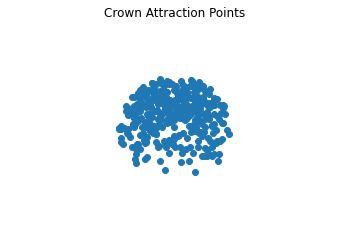

	REPORT FOR ITERATION 10
Number of nodes: 11
Number of attraction points: 363



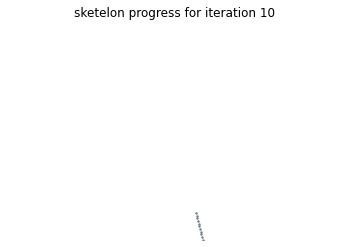


	REPORT FOR ITERATION 20
Number of nodes: 21
Number of attraction points: 363



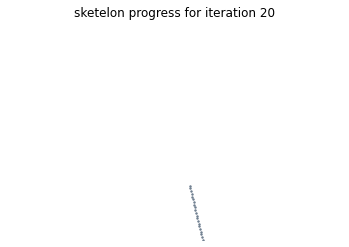


	REPORT FOR ITERATION 30
Number of nodes: 38
Number of attraction points: 360



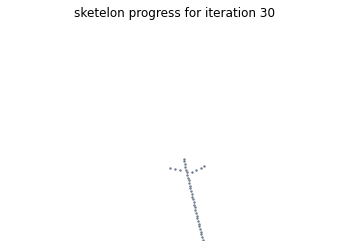


	REPORT FOR ITERATION 40
Number of nodes: 95
Number of attraction points: 310



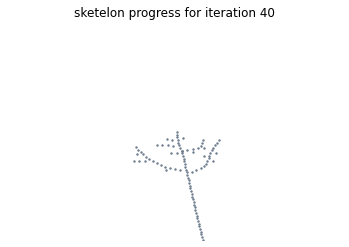


	REPORT FOR ITERATION 50
Number of nodes: 188
Number of attraction points: 176



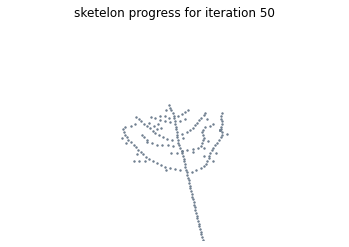


	REPORT FOR ITERATION 50
Number of nodes: 188
Number of attraction points: 176



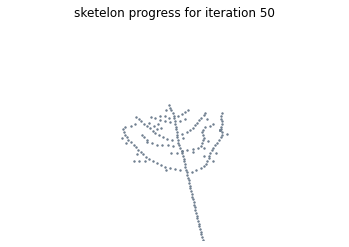

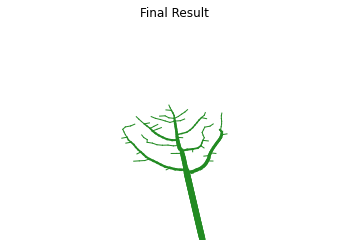

In [21]:
def run_experiment_ellispe_crown_1():
  mean = [0.3, 5.5]
  cov = [[1, 0], [0.6, 2]]

  x, y = np.random.multivariate_normal(mean, cov, 1000).T

  t = np.square(x) + np.square(y-4)/4 <= 1

  x_crown = x[t]
  y_crown = y[t]

  plt.plot(x_crown, y_crown, 'o')
  plt.title('Crown Attraction Points')
  plt.axis('off')
  plt.xlim(-3, 3)
  plt.ylim(0, 8)

  plt.show()

  sim = Simulation(crown_attraction_points=(x_crown, y_crown), radius_of_influence = 5, kill_distance = 0.1, D = 0.1, brach_min_width=1)
  sim.run(50)

  del sim


run_experiment_ellispe_crown_1()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


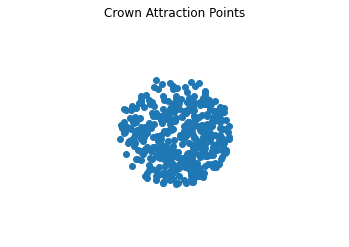

	REPORT FOR ITERATION 10
Number of nodes: 11
Number of attraction points: 417



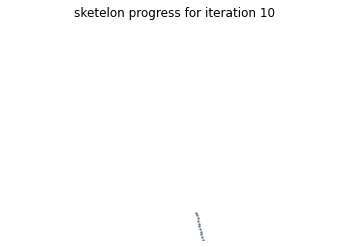


	REPORT FOR ITERATION 20
Number of nodes: 21
Number of attraction points: 417



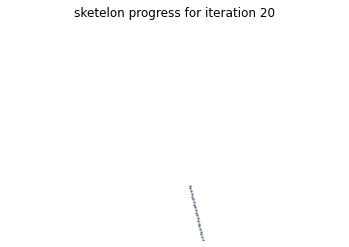


	REPORT FOR ITERATION 30
Number of nodes: 59
Number of attraction points: 345



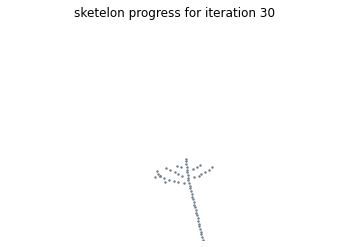


	REPORT FOR ITERATION 40
Number of nodes: 149
Number of attraction points: 211



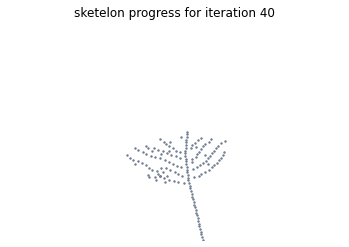


	REPORT FOR ITERATION 50
Number of nodes: 237
Number of attraction points: 71



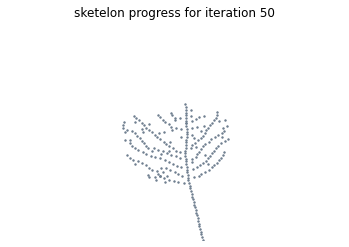


	REPORT FOR ITERATION 60
Number of nodes: 302
Number of attraction points: 4



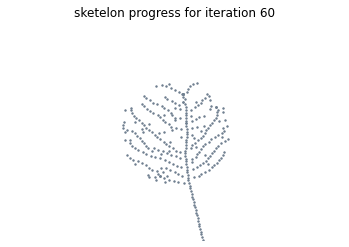


	REPORT FOR ITERATION 60
Number of nodes: 302
Number of attraction points: 4



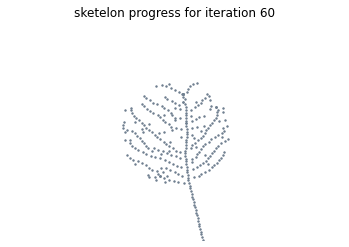

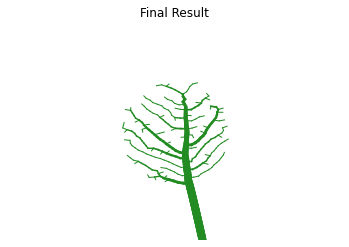

In [51]:
def run_experiment_ellispe_crown_2():
  mean = [0.3, 3.5]
  cov = [[1, 0.5], [0.6, 3]]

  x, y = np.random.multivariate_normal(mean, cov, 1000).T

  t = np.square(x) + np.square(y-4)/4 <= 1

  x_crown = x[t]
  y_crown = y[t]

  plt.plot(x_crown, y_crown, 'o')
  plt.title('Crown Attraction Points')
  plt.axis('off')
  plt.xlim(-3, 3)
  plt.ylim(0, 8)

  plt.show()

  sim = Simulation(crown_attraction_points=(x_crown, y_crown), radius_of_influence = np.inf, kill_distance = 0.1, D = 0.1, brach_min_width=1)
  sim.run(60)

  del sim


run_experiment_ellispe_crown_2()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


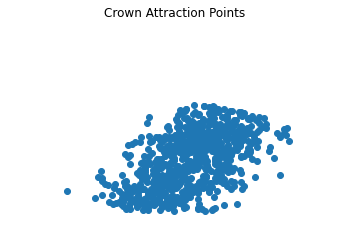

	REPORT FOR ITERATION 10
Number of nodes: 11
Number of attraction points: 753



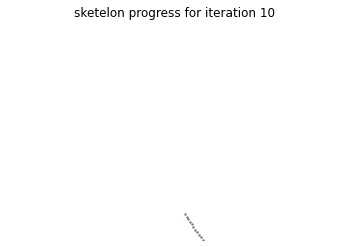


	REPORT FOR ITERATION 20
Number of nodes: 61
Number of attraction points: 679



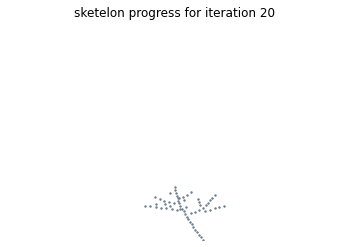


	REPORT FOR ITERATION 30
Number of nodes: 207
Number of attraction points: 451



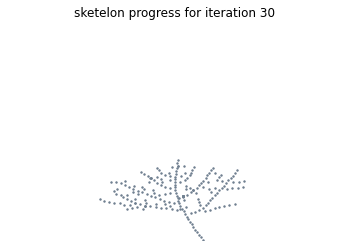


	REPORT FOR ITERATION 40
Number of nodes: 360
Number of attraction points: 213



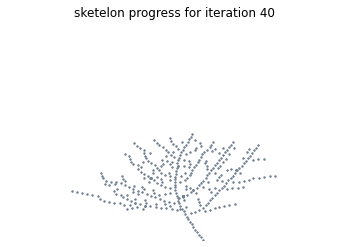


	REPORT FOR ITERATION 50
Number of nodes: 498
Number of attraction points: 32



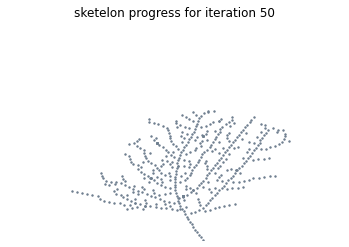


	REPORT FOR ITERATION 50
Number of nodes: 498
Number of attraction points: 32



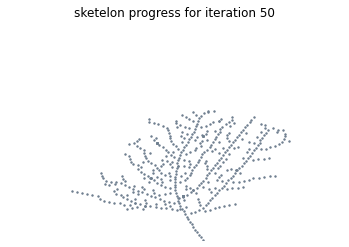

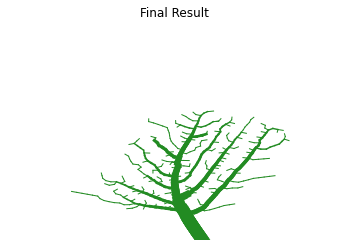

In [60]:
def run_experiment_ellispe_crown_3():
  mean = [0.3, 3]
  cov = [[1, 2], [0.6, 2]]

  x, y = np.random.multivariate_normal(mean, cov, 1000).T

  t = np.square(x)/6 + np.square(y-3)/4 <= 1

  x_crown = x[t]
  y_crown = y[t]

  plt.plot(x_crown, y_crown, 'o')
  plt.title('Crown Attraction Points')
  plt.axis('off')
  plt.xlim(-3, 3)
  plt.ylim(0, 8)

  plt.show()

  sim = Simulation(crown_attraction_points=(x_crown, y_crown), radius_of_influence = 2, kill_distance = 0.1, D = 0.1, brach_min_width=1)
  sim.run(50)

  del sim


run_experiment_ellispe_crown_3()

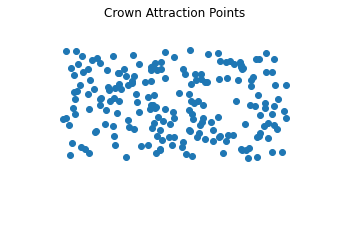

	REPORT FOR ITERATION 10
Number of nodes: 11
Number of attraction points: 200



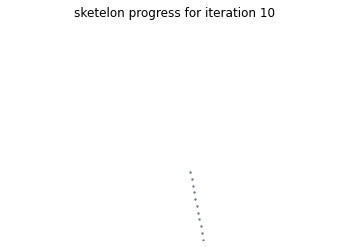


	REPORT FOR ITERATION 20
Number of nodes: 47
Number of attraction points: 137



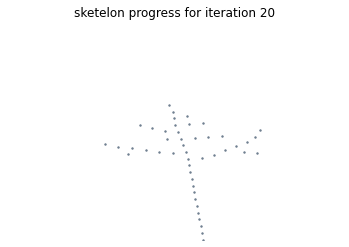


	REPORT FOR ITERATION 30
Number of nodes: 126
Number of attraction points: 2



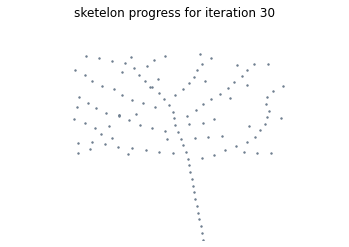


	REPORT FOR ITERATION 31
Number of nodes: 128
Number of attraction points: 0



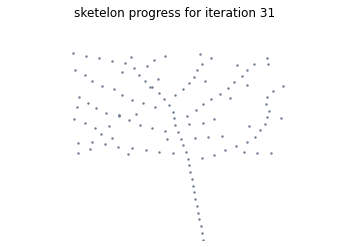

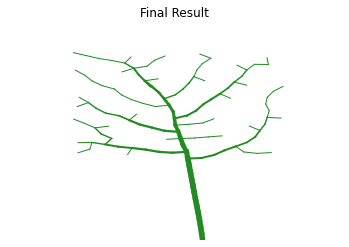

In [36]:
def run_experiment_uniform_square_crown():
  x = np.random.uniform(-2, 2, size=200)
  y = np.random.uniform(3, 7, size=200)
  x_crown = x
  y_crown = y

  plt.plot(x_crown, y_crown, 'o')
  plt.title('Crown Attraction Points')
  plt.axis('off')
  plt.xlim(-3, 3)
  plt.ylim(0, 8)

  plt.show()

  sim = Simulation(crown_attraction_points=(x_crown, y_crown), radius_of_influence = 4, kill_distance = 0.01, D = 0.05, brach_min_width=1)

  sim.run(50)

run_experiment()

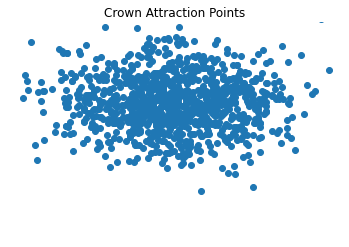

	REPORT FOR ITERATION 10
Number of nodes: 11
Number of attraction points: 1000



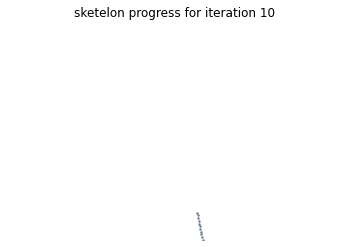


	REPORT FOR ITERATION 20
Number of nodes: 22
Number of attraction points: 999



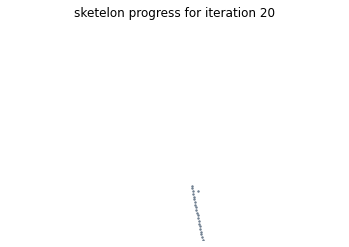


	REPORT FOR ITERATION 30
Number of nodes: 46
Number of attraction points: 993



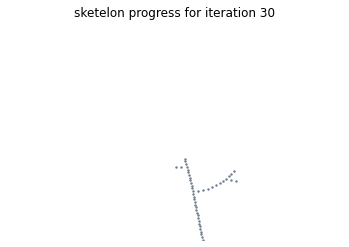


	REPORT FOR ITERATION 40
Number of nodes: 120
Number of attraction points: 943



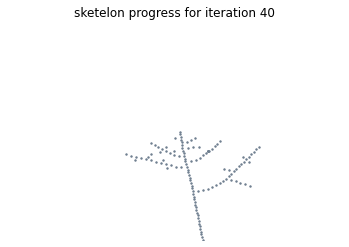


	REPORT FOR ITERATION 50
Number of nodes: 303
Number of attraction points: 714



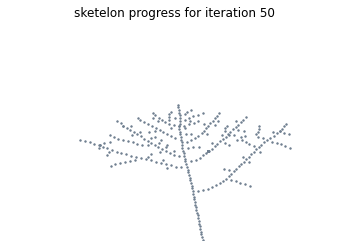


	REPORT FOR ITERATION 50
Number of nodes: 303
Number of attraction points: 714



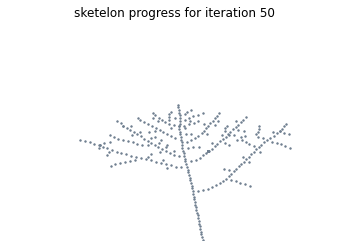

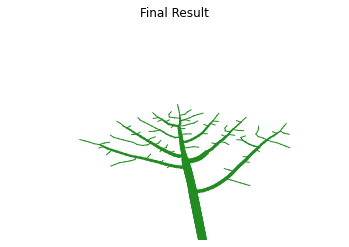

In [52]:
def run_experiment_multivariate_normal_crown():
  mean = [0, 5]
  cov = [[1, 0], [0, 1]]

  x, y = np.random.multivariate_normal(mean, cov, 1000).T


  plt.plot(x, y, 'o')
  plt.title('Crown Attraction Points')
  plt.axis('off')
  plt.xlim(-3, 3)
  plt.ylim(0, 8)

  plt.show()

  sim = Simulation(crown_attraction_points=(x, y), radius_of_influence = np.inf, kill_distance = 0.1, D = 0.1, brach_min_width=1)
  sim.run(50)

  del sim


run_experiment_multivariate_normal_crown()